## Question Answering

We got the documents we want to chat on, loaded them, embedded them, store them in a vectorstore, went over how to retrieve relevant documents, now let's use these relevant documents to answer question we had originaly.

How the retrieve QA works:

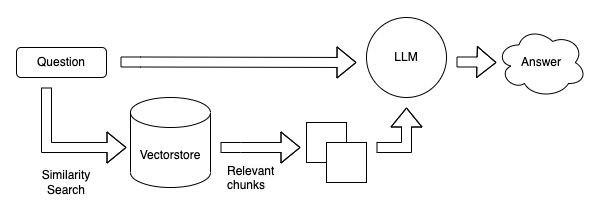

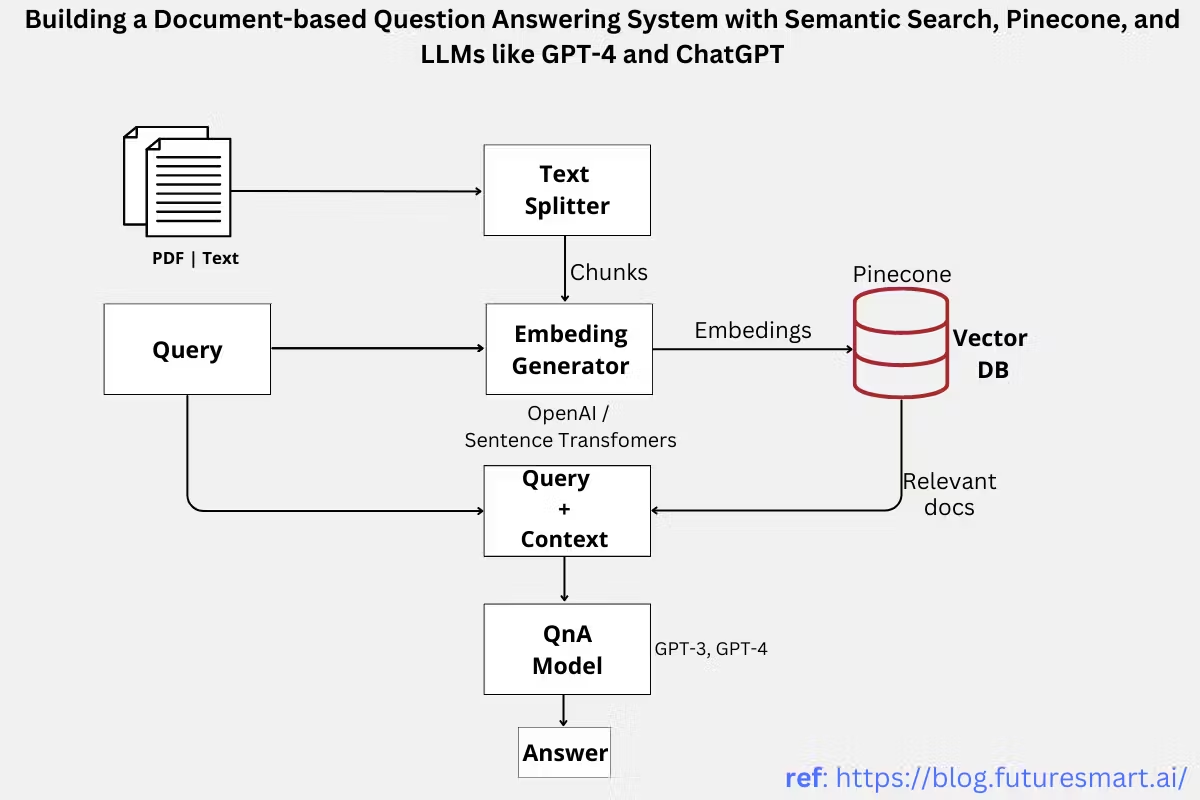

Downside of the architecture at times, is that there is too much documents to pass to the LLM(expensive, tokens). There are a couple of ways around this:

1. Map Reduce
2. Map Rerank
3. Refine

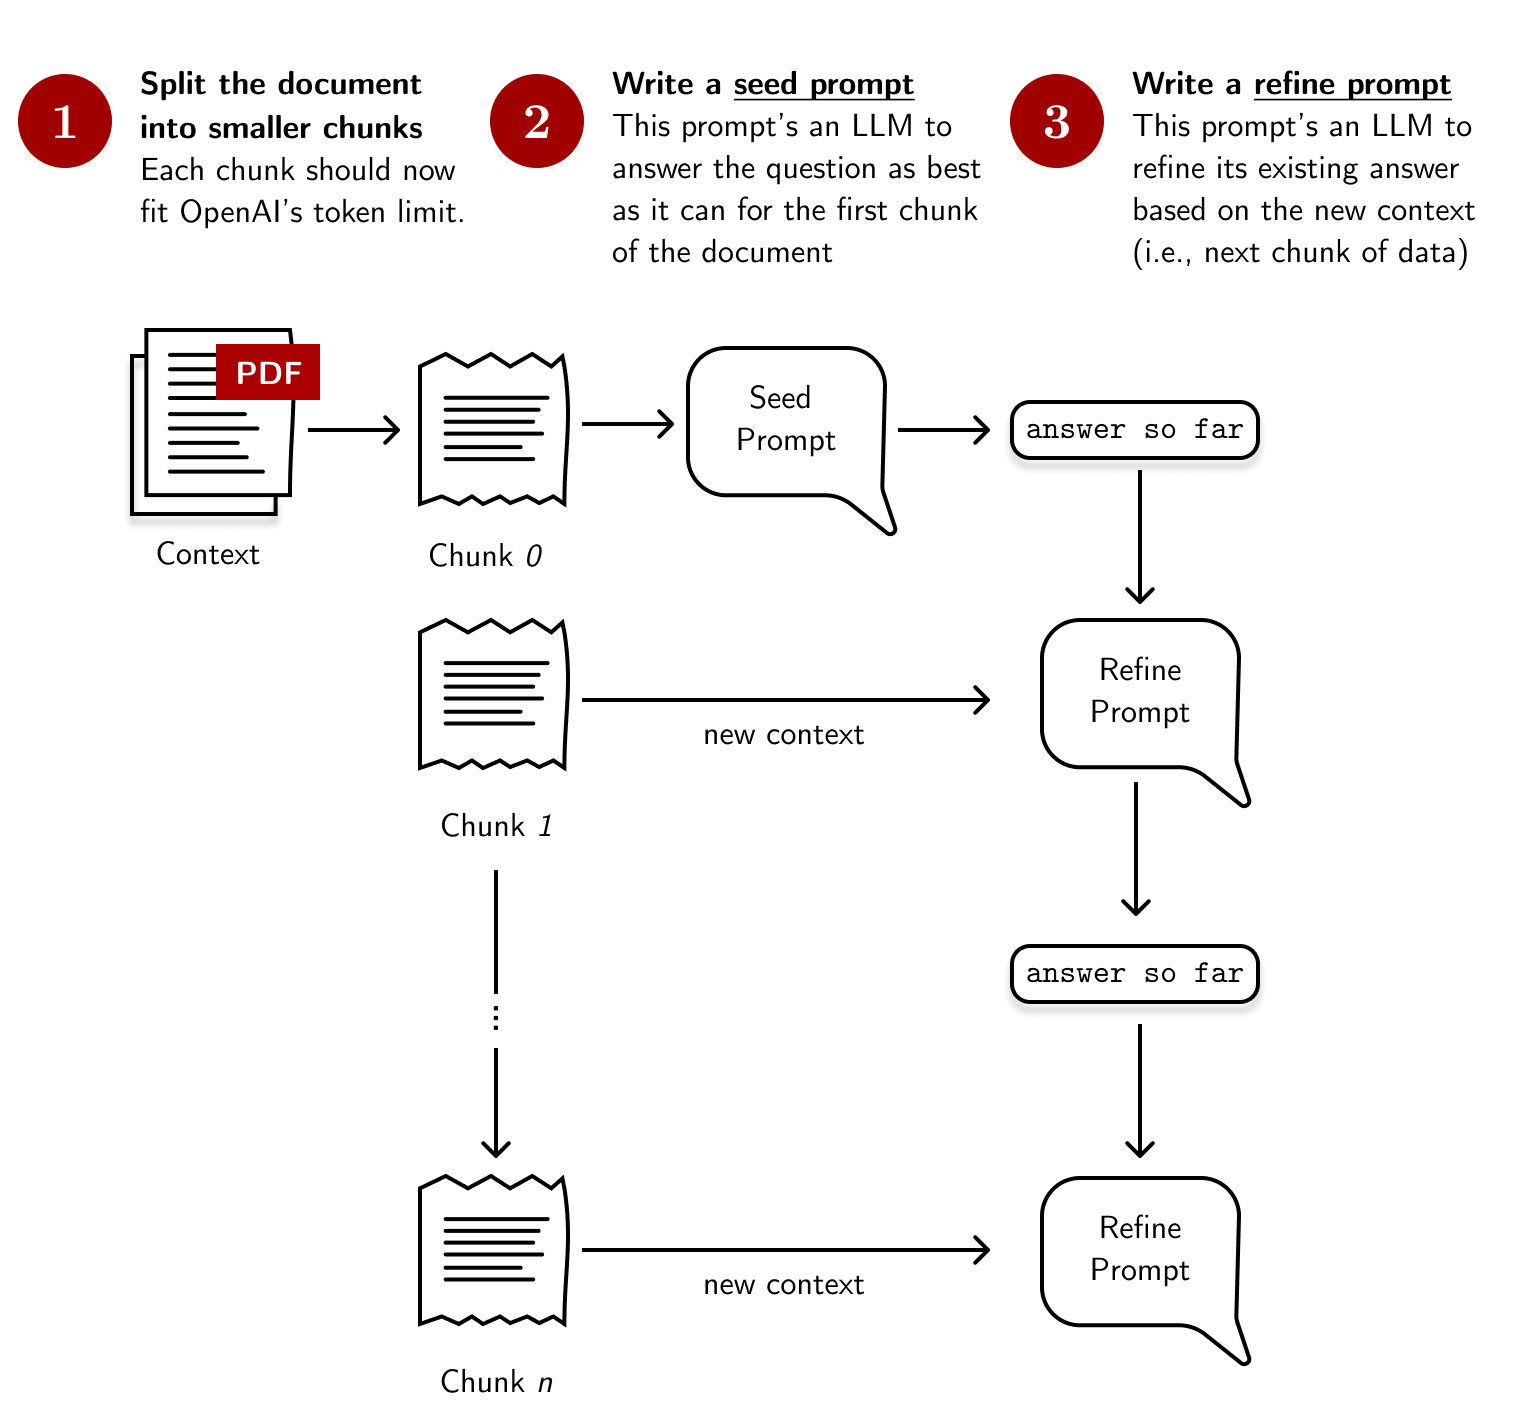

In [1]:
from dotenv import load_dotenv
import os

%load_ext dotenv
%dotenv

In [2]:
openai_api_key  = os.environ['OPANAI_API_KEY']

In [3]:
from langchain.vectorstores import Chroma

In [10]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = './vecstores/chroma'

In [11]:
embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [13]:
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [15]:
print(vectordb._collection.count())

26


We use `temperature=0` to get factual answers and avoid variations in answers(reduce entropy)

In [18]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature=0, openai_api_key=openai_api_key)

## RetrievalQA Chain

### Stuff Method / Overfill: 

All the documents are sent along with the question to the LLM. This is expensive.

You can read more about this:

```python
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
```

In [19]:
from langchain.chains import RetrievalQA

In [20]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [21]:
question = "Is there a point where we go over function parameters"

In [22]:
result = qa_chain({"query": question})

In [23]:
result

{'query': 'Is ther a point where we go over function parameters',
 'result': "Yes, in TypeScript, there are several ways to handle function parameters. \n\n1. Rest Parameters: TypeScript allows you to define a function with a variable number of arguments using rest parameters. Rest parameters are denoted by three dots (...) followed by the parameter name. This allows you to pass any number of arguments to the function, and they will be treated as an array within the function.\n\n2. Function Overloading: TypeScript supports function overloading, which means you can define multiple function signatures for the same function name. This allows you to have different sets of parameters or return types for different use cases. The appropriate function implementation will be chosen based on the arguments provided when calling the function.\n\n3. Optional Parameters: TypeScript allows you to mark function parameters as optional by adding a question mark (?) after the parameter name. Optional par

In [33]:
response = result.get("result")

In [31]:
def pretify_response(response):
    for i, doc in enumerate(response):
        response = response.replace("\n", " ")
        return response

In [34]:
pretify_response(response)

"Yes, in TypeScript, there are several ways to handle function parameters.   1. Rest Parameters: TypeScript allows you to define a function with a variable number of arguments using rest parameters. Rest parameters are denoted by three dots (...) followed by the parameter name. This allows you to pass any number of arguments to the function, and they will be treated as an array within the function.  2. Function Overloading: TypeScript supports function overloading, which means you can define multiple function signatures for the same function name. This allows you to have different sets of parameters or return types for different use cases. The appropriate function implementation will be chosen based on the arguments provided when calling the function.  3. Optional Parameters: TypeScript allows you to mark function parameters as optional by adding a question mark (?) after the parameter name. Optional parameters can be omitted when calling the function, and their value will be undefined

Adding prompts

In [35]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [36]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [39]:
result = qa_chain({"query": question})

In [40]:
pretify_response(result["result"])

'Yes, TypeScript allows for function overloading, which means you can define multiple function signatures for a single function name. This allows you to have different sets of parameters for different use cases. Thanks for asking!'

###### Which documents where sent along with the question and the system prompt?

In [41]:
result["source_documents"]

[Document(page_content='#TypeScriptRestParameters\n#TypeScriptFunctionOverloading\n#TypeScriptArrowFunctions', metadata={'source': './datasets/example_doc.pdf', 'page': 0}),
 Document(page_content='#TypeScriptFunctionParameters\n#TypeScriptOptionalParameters\n#TypeScriptDefaultParameters', metadata={'source': './datasets/example_doc.pdf', 'page': 0}),
 Document(page_content='variable\nnumber\nof\narguments.\n5.\nFunction\nOverloading:\nUnderstand\nfunction\noverloading\nin', metadata={'source': './datasets/example_doc.pdf', 'page': 0}),
 Document(page_content='which\ncan\naccept\nfunctions\nas\nparameters\nor\nreturn\nfunctions,\nenabling\npowerful\nabstractions\nin', metadata={'source': './datasets/example_doc.pdf', 'page': 0})]

### Map Reduce, Map Rerand and Refine Method Of RetrievalQA

The main reason for this other than expenses is that, we have to keep in mind the `context window`. When the document is too large, the content will not fit in the context window of the LLM. In such cases we hace to apply one of this methods.

In [46]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [47]:
result = qa_chain_mr({"query": question})

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-O63i5PQ7Ilb4Mxa9yYj1duhx on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-O63i5PQ7Ilb4Mxa9yYj1duhx on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

In [48]:
pretify_response(result["result"])

'Yes, there is a point where we go over function parameters. In TypeScript, we can use rest parameters to represent an indefinite number of arguments as an array. This allows us to pass a variable number of arguments to a function. Additionally, TypeScript supports function overloading, which means we can define multiple function signatures for a single function name. This allows us to have different sets of parameters for different use cases. Lastly, TypeScript also supports arrow functions, which are a concise way to define functions using the arrow (=>) syntax.'

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [ ]:
result = qa_chain_mr({"query": question})

In [53]:
pretify_response(result["result"])

'Yes, there is a point where we go over function parameters in TypeScript.'

In [ ]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)

In [55]:
result = qa_chain_mr({"query": question})

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-O63i5PQ7Ilb4Mxa9yYj1duhx on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-O63i5PQ7Ilb4Mxa9yYj1duhx on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

In [56]:
pretify_response(result["result"])

"In TypeScript, you can define functions that accept other functions as parameters or return functions as their result. This feature is known as higher-order functions and it enables powerful abstractions and functional programming techniques.  Higher-order functions allow you to pass functions as arguments to other functions, which can then be invoked within the receiving function. This allows for dynamic behavior and customization of functionality. Here's an example:  ```typescript function applyOperation(a: number, b: number, operation: (x: number, y: number) => number): number {   return operation(a, b); }  function add(a: number, b: number): number {   return a + b; }  function multiply(a: number, b: number): number {   return a * b; }  console.log(applyOperation(2, 3, add)); // Output: 5 console.log(applyOperation(2, 3, multiply)); // Output: 6 ```  In the above example, the `applyOperation` function accepts two numbers (`a` and `b`) and a function (`operation`) as parameters. Th

If you wish to experiment on the LangChain plus platform:

- Go to [langchain plus platform](https://www.langchain.plus/) and sign up
- Create an API key from your account's settings
- Use this API key in the code below
- uncomment the code

Note, the endpoint in the video differs from the one below. Use the one below.

```python
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..." # replace dots with your api key
```